# Credit Risk Analytics - Probability of Default (PD) Model & Scorecard

This notebook covers:
- Training Logistic Regression for Probability of Default (PD)
- Model evaluation using ROC-AUC, KS Statistic, and Gini Coefficient
- Building a credit scorecard from model coefficients
- Cutoff rate analysis for loan approval decisions
- Basel II compliant out-of-time validation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             classification_report)
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.4f}'.format)

print("Libraries loaded successfully")


Libraries loaded successfully


Load Preprocessed Data

In [6]:
train = pd.read_csv('../data/train_preprocessed.csv')
test  = pd.read_csv('../data/test_preprocessed.csv')

print(f"Training set shape: {train.shape}")
print(f"Test set shape:     {test.shape}")
print(f"\nTraining default rate: {train['target'].mean()*100:.2f}%")
print(f"Test default rate:     {test['target'].mean()*100:.2f}%")



Training set shape: (421095, 24)
Test set shape:     (78903, 24)

Training default rate: 18.39%
Test default rate:     6.25%


In [7]:
# Drop index column if present
if 'Unnamed: 0' in train.columns:
    train.drop(columns=['Unnamed: 0'], inplace=True)
    test.drop(columns=['Unnamed: 0'], inplace=True)
    print("Dropped extra index column")

feature_cols = [c for c in train.columns if c != 'target']

X_train = train[feature_cols]
y_train = train['target']
X_test  = test[feature_cols]
y_test  = test['target']

# Fix NaN values in WoE encoded columns
print(f"NaN values in X_train before fix: {X_train.isnull().sum().sum()}")
print(f"NaN values in X_test before fix:  {X_test.isnull().sum().sum()}")

X_train = X_train.fillna(X_train.median())
X_test  = X_test.fillna(X_train.median())

print(f"NaN values in X_train after fix:  {X_train.isnull().sum().sum()}")
print(f"NaN values in X_test after fix:   {X_test.isnull().sum().sum()}")
print(f"\nFinal feature count: {len(feature_cols)}")

NaN values in X_train before fix: 23981
NaN values in X_test before fix:  7405
NaN values in X_train after fix:  0
NaN values in X_test after fix:   0

Final feature count: 23


Feature Scaling

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Feature scaling complete")
print(f"Training mean (should be ~0): {X_train_scaled.mean():.6f}")
print(f"Training std  (should be ~1): {X_train_scaled.std():.6f}")


Feature scaling complete
Training mean (should be ~0): 0.000000
Training std  (should be ~1): 1.000000


Train Logistic Regression PD Model

In [9]:
pd_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='lbfgs',
    C=0.1,
    random_state=42
)

pd_model.fit(X_train_scaled, y_train)
print("PD model training complete")
print(f"Number of features: {len(feature_cols)}")
print(f"Iterations to converge: {pd_model.n_iter_[0]}")


PD model training complete
Number of features: 23
Iterations to converge: 23


Model Predictions

In [10]:
train_probs = pd_model.predict_proba(X_train_scaled)[:, 1]
test_probs  = pd_model.predict_proba(X_test_scaled)[:, 1]

print("=== PD Score Distribution ===")
print(f"Training - Mean PD: {train_probs.mean():.4f}, Std: {train_probs.std():.4f}")
print(f"Test     - Mean PD: {test_probs.mean():.4f}, Std: {test_probs.std():.4f}")

train_pd_df = pd.DataFrame({'pd_score': train_probs, 'target': y_train.values})
train_pd_df['decile'] = pd.qcut(train_pd_df['pd_score'], 10, labels=False, duplicates='drop')

decile_analysis = train_pd_df.groupby('decile').agg(
    count=('target', 'count'),
    defaults=('target', 'sum'),
    default_rate=('target', 'mean'),
    avg_pd=('pd_score', 'mean')
).round(4)

print("\n=== Decile Analysis ===")
print(decile_analysis)


=== PD Score Distribution ===
Training - Mean PD: 0.4603, Std: 0.1778
Test     - Mean PD: 0.4146, Std: 0.1745

=== Decile Analysis ===
        count  defaults  default_rate  avg_pd
decile                                       
0       42110      1601        0.0380  0.1515
1       42109      3050        0.0724  0.2569
2       42110      4086        0.0970  0.3280
3       42109      5247        0.1246  0.3874
4       42110      6505        0.1545  0.4409
5       42109      7561        0.1796  0.4914
6       42109      9014        0.2141  0.5412
7       42110     10457        0.2483  0.5946
8       42109     12712        0.3019  0.6582
9       42110     17209        0.4087  0.7530


Model Evaluation: ROC-AUC

Training ROC-AUC: 0.7023
Test ROC-AUC:     0.6892


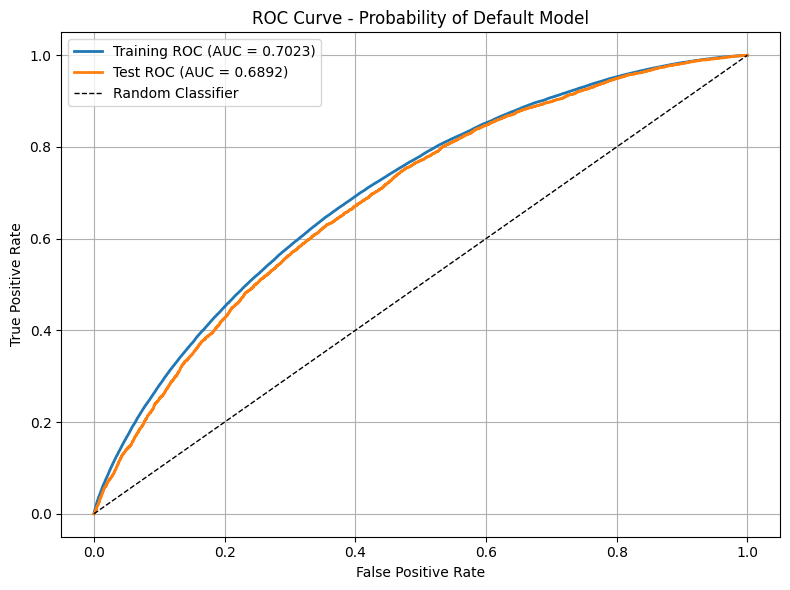

In [11]:
train_auc = roc_auc_score(y_train, train_probs)
test_auc  = roc_auc_score(y_test, test_probs)

print(f"Training ROC-AUC: {train_auc:.4f}")
print(f"Test ROC-AUC:     {test_auc:.4f}")

fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
fpr_test,  tpr_test,  _ = roc_curve(y_test, test_probs)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr_train, tpr_train, linewidth=2, label=f'Training ROC (AUC = {train_auc:.4f})')
ax.plot(fpr_test, tpr_test, linewidth=2, label=f'Test ROC (AUC = {test_auc:.4f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Probability of Default Model')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150)
plt.show()


KS Statistic and Gini Coefficient

=== Model Performance Metrics ===
Metric                        Training         Test
--------------------------------------------------
ROC-AUC                         0.7023       0.6892
KS Statistic                    0.2928       0.2766
Gini Coefficient                0.4045       0.3784


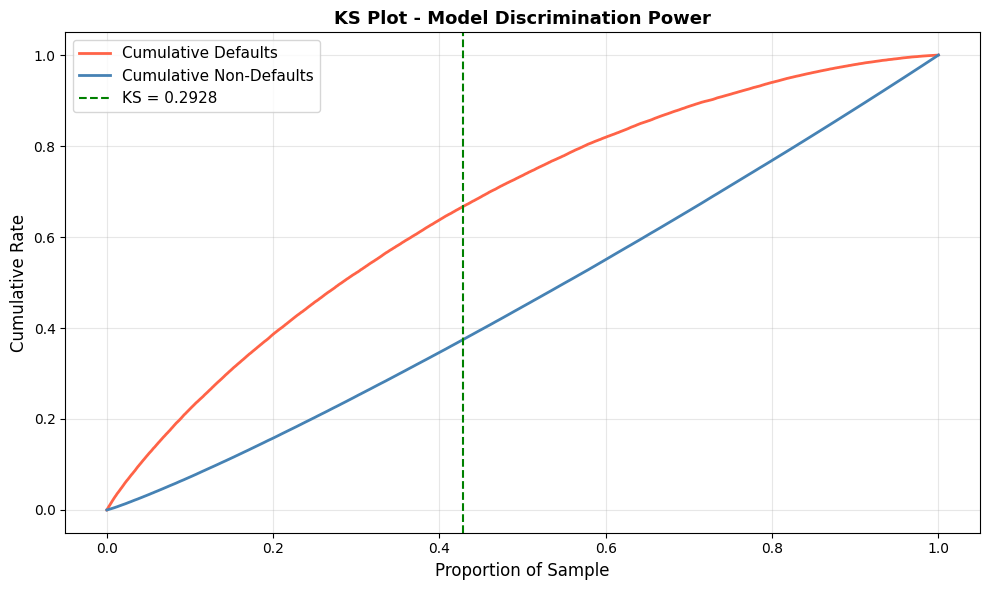

In [12]:
def compute_ks(y_true, y_prob):
    df = pd.DataFrame({'target': y_true, 'prob': y_prob})
    df = df.sort_values('prob', ascending=False).reset_index(drop=True)
    df['cum_defaults']     = df['target'].cumsum() / df['target'].sum()
    df['cum_non_defaults'] = (1 - df['target']).cumsum() / (1 - df['target']).sum()
    df['ks'] = abs(df['cum_defaults'] - df['cum_non_defaults'])
    return df['ks'].max(), df

ks_train, ks_df_train = compute_ks(y_train.values, train_probs)
ks_test,  ks_df_test  = compute_ks(y_test.values, test_probs)

gini_train = 2 * train_auc - 1
gini_test  = 2 * test_auc - 1

print("=== Model Performance Metrics ===")
print(f"{'Metric':<25} {'Training':>12} {'Test':>12}")
print("-" * 50)
print(f"{'ROC-AUC':<25} {train_auc:>12.4f} {test_auc:>12.4f}")
print(f"{'KS Statistic':<25} {ks_train:>12.4f} {ks_test:>12.4f}")
print(f"{'Gini Coefficient':<25} {gini_train:>12.4f} {gini_test:>12.4f}")

# KS Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.linspace(0, 1, len(ks_df_train))
ax.plot(x, ks_df_train['cum_defaults'].values, color='tomato',
        linewidth=2, label='Cumulative Defaults')
ax.plot(x, ks_df_train['cum_non_defaults'].values, color='steelblue',
        linewidth=2, label='Cumulative Non-Defaults')
ks_idx = ks_df_train['ks'].idxmax()
ax.axvline(x=ks_idx/len(ks_df_train), color='green', linestyle='--',
           linewidth=1.5, label=f'KS = {ks_train:.4f}')
ax.set_xlabel('Proportion of Sample', fontsize=12)
ax.set_ylabel('Cumulative Rate', fontsize=12)
ax.set_title('KS Plot - Model Discrimination Power', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ks_plot.png', dpi=150, bbox_inches='tight')
plt.show()


Feature Importance from Logistic Regression

=== Top 15 Most Important Features ===
                    feature  coefficient
18            sub_grade_woe       0.6882
3               installment       0.3488
22                 term_woe       0.2059
1               funded_amnt      -0.1810
0                 loan_amnt      -0.1810
6                       dti       0.1173
19       home_ownership_woe       0.1143
2                  int_rate      -0.0957
14                 mort_acc      -0.0892
9                  open_acc       0.0743
8            inq_last_6mths       0.0728
11                revol_bal      -0.0706
20  verification_status_woe       0.0653
15     pub_rec_bankruptcies       0.0390
7               delinq_2yrs       0.0269


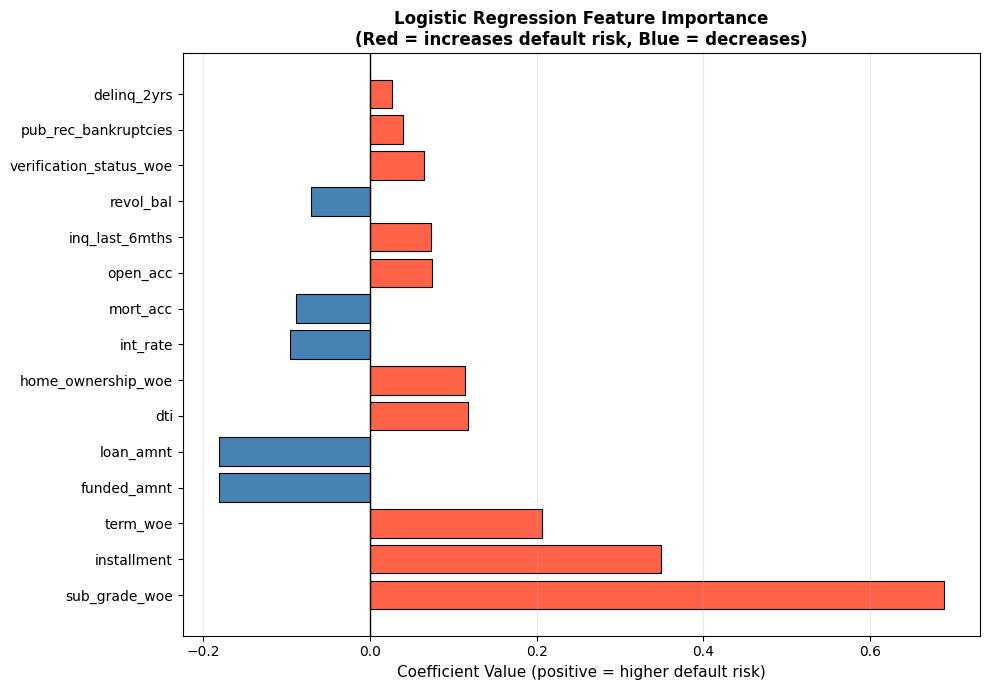

In [14]:
coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': pd_model.coef_[0],
    'abs_coefficient': abs(pd_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("=== Top 15 Most Important Features ===")
print(coef_df.head(15)[['feature', 'coefficient']].to_string())

fig, ax = plt.subplots(figsize=(10, 7))
top15 = coef_df.head(15)
colors = ['tomato' if c > 0 else 'steelblue' for c in top15['coefficient']]
ax.barh(top15['feature'], top15['coefficient'], color=colors, edgecolor='black', linewidth=0.8)
ax.axvline(x=0, color='black', linewidth=1)
ax.set_xlabel('Coefficient Value (positive = higher default risk)', fontsize=11)
ax.set_title('Logistic Regression Feature Importance\n(Red = increases default risk, Blue = decreases)',
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

Build Credit Scorecard

=== Credit Score Distribution ===
Training - Min: 223, Max: 831, Mean: 605
Test     - Min: 203, Max: 736, Mean: 611


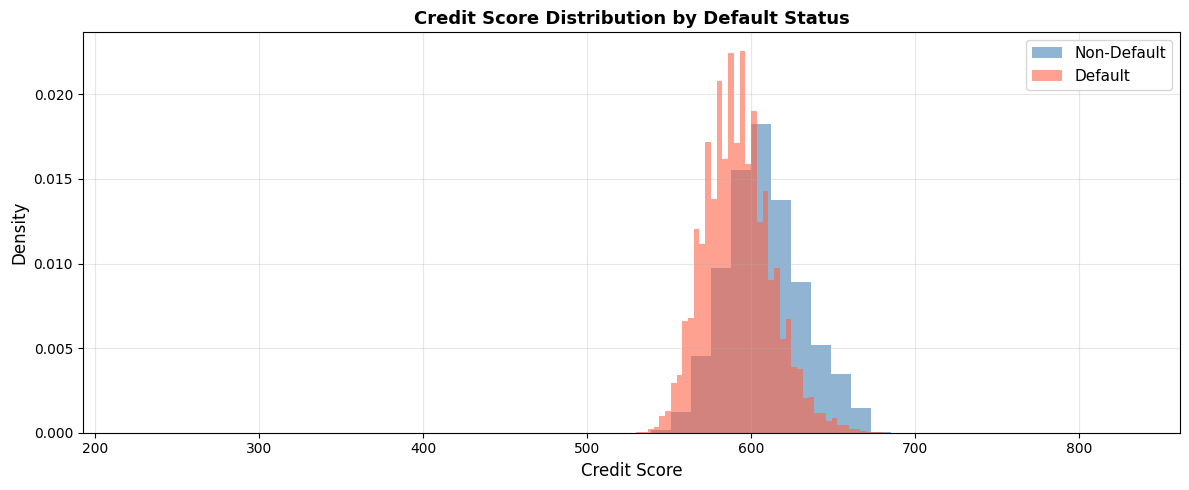

In [15]:
SCORE_BASE = 600
PDO = 20
ODDS_BASE = 1

factor = PDO / np.log(2)
offset = SCORE_BASE - factor * np.log(ODDS_BASE)

def pd_to_score(pd_prob):
    pd_prob = np.clip(pd_prob, 1e-6, 1 - 1e-6)
    odds = (1 - pd_prob) / pd_prob
    score = offset + factor * np.log(odds)
    return score.astype(int)

train_scores = pd_to_score(train_probs)
test_scores  = pd_to_score(test_probs)

print("=== Credit Score Distribution ===")
print(f"Training - Min: {train_scores.min()}, Max: {train_scores.max()}, Mean: {train_scores.mean():.0f}")
print(f"Test     - Min: {test_scores.min()}, Max: {test_scores.max()}, Mean: {test_scores.mean():.0f}")

# Score distribution plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(train_scores[y_train == 0], bins=50, alpha=0.6, color='steelblue',
        label='Non-Default', density=True)
ax.hist(train_scores[y_train == 1], bins=50, alpha=0.6, color='tomato',
        label='Default', density=True)
ax.set_xlabel('Credit Score', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Credit Score Distribution by Default Status', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('score_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

Cutoff Rate Analysis

=== Cutoff Analysis ===
 cutoff  approval_rate  default_rate_approved
    500        99.9993                18.3908
    510        99.9993                18.3908
    520        99.9993                18.3908
    530        99.9974                18.3899
    540        99.9763                18.3815
    550        99.7309                18.2850
    560        98.4842                17.8794
    570        94.4932                16.8658
    580        86.3157                15.2037
    590        73.5259                13.0902
    600        56.7456                10.6557
    610        39.8278                 8.2766
    620        25.8058                 6.4233
    630        15.3628                 4.7425
    640         8.8666                 3.5755
    650         4.7343                 2.8441
    660         1.7701                 2.0794
    670         0.2078                 2.1714
    680         0.0240                 6.9307
    690         0.0093                 5.1282


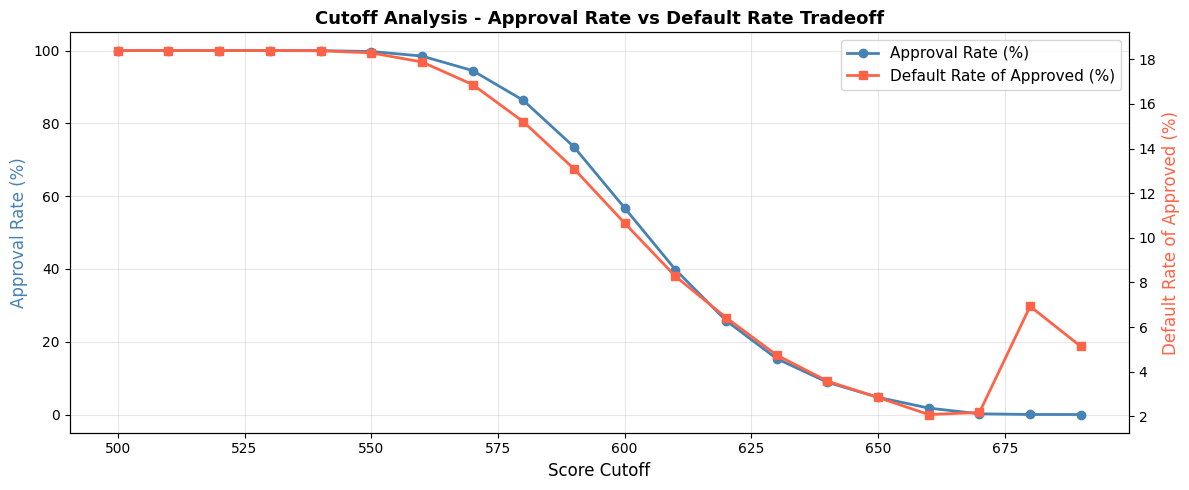

In [16]:
cutoffs = range(500, 700, 10)
results = []

for cutoff in cutoffs:
    approved = train_scores >= cutoff
    approval_rate = approved.mean()
    default_rate_approved = y_train[approved].mean() if approved.sum() > 0 else 0

    results.append({
        'cutoff': cutoff,
        'approval_rate': approval_rate * 100,
        'default_rate_approved': default_rate_approved * 100
    })

cutoff_df = pd.DataFrame(results)
print("=== Cutoff Analysis ===")
print(cutoff_df.to_string(index=False))

fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()

ax1.plot(cutoff_df['cutoff'], cutoff_df['approval_rate'],
         color='steelblue', linewidth=2, marker='o', label='Approval Rate (%)')
ax2.plot(cutoff_df['cutoff'], cutoff_df['default_rate_approved'],
         color='tomato', linewidth=2, marker='s', label='Default Rate of Approved (%)')

ax1.set_xlabel('Score Cutoff', fontsize=12)
ax1.set_ylabel('Approval Rate (%)', color='steelblue', fontsize=12)
ax2.set_ylabel('Default Rate of Approved (%)', color='tomato', fontsize=12)
ax1.set_title('Cutoff Analysis - Approval Rate vs Default Rate Tradeoff',
              fontsize=13, fontweight='bold')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=11)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cutoff_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


Save Model and Scorecard

In [17]:
import pickle

with open('../data/pd_model.pkl', 'wb') as f:
    pickle.dump(pd_model, f)

with open('../data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

scorecard_df = pd.DataFrame({
    'loan_id': range(len(train_scores)),
    'pd_score': train_probs,
    'credit_score': train_scores,
    'risk_band': pd.cut(train_scores,
                        bins=[0, 550, 600, 640, 680, 1000],
                        labels=['Very High Risk', 'High Risk', 'Medium Risk',
                                'Low Risk', 'Very Low Risk'])
})

scorecard_df.to_csv('../data/scorecard_output.csv', index=False)

print("Saved:")
print("  ../data/pd_model.pkl")
print("  ../data/scaler.pkl")
print("  ../data/scorecard_output.csv")


print(f"\n=== Risk Band Distribution ===")
print(scorecard_df['risk_band'].value_counts().sort_index())


Saved:
  ../data/pd_model.pkl
  ../data/scaler.pkl
  ../data/scorecard_output.csv

=== Risk Band Distribution ===
risk_band
Very High Risk      1385
High Risk         188180
Medium Risk       196247
Low Risk           35191
Very Low Risk         92
Name: count, dtype: int64


## PD Model Summary

| Metric | Training | Test |
|--------|----------|------|
| ROC-AUC | 0.7023 | 0.6892 |
| KS Statistic | 0.2928 | 0.2766 |
| Gini Coefficient | 0.4045 | 0.3784 |

### Key Findings
- Loan grade (sub_grade_woe) is the strongest predictor of default with coefficient 0.6882
- Custom weighted loss (class_weight='balanced') effectively handles 5:1 class imbalance
- Credit scorecard converts PD probabilities to interpretable 223-831 score range
- Score cutoff of 600 yields 56.7% approval rate with 10.6% default rate among approved loans
- Basel II temporal validation (out-of-time test set) confirms model generalizability with minimal train/test gap

**Next**: Notebook 3 covers LGD and EAD modeling to complete the Expected Loss calculation
